<a href="https://colab.research.google.com/github/shanilev123456/Final-Project-ds/blob/master/FCNN_model%26Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import copy

!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.8 s (started: 2025-06-11 12:50:42 +03:00)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Data

In [164]:
# from google.colab import files
# uploaded = files.upload()

time: 0 ns (started: 2025-06-11 12:50:44 +03:00)


In [165]:
df = pd.read_csv("cleaned_data.csv")
df.head()

,City,Units,Area m2,dist_to_kindergarten,is_kindergarten_within_radius,dist_to_school,is_school_within_radius,dist_to_university,is_university_within_radius,dist_to_bus_stop,...,Committee_year_2023.0,Committee_year_2024.0,Committee_year_2025.0,Region_דרום,Region_חיפה,Region_ירושלים,Region_מרכז,Region_צפון,Region_תל אביב,City_Index
0,"זכרון יעקב , מורדות הבאר",0.2,0.639225,0.012903,1,0.018328,1,0.330703,0,0.031822,...,0,0,0,0,1,0,0,0,0,0
1,"זכרון יעקב , מורדות הבאר",0.2,0.638015,0.012903,1,0.018328,1,0.330703,0,0.031822,...,0,0,0,0,1,0,0,0,0,0
2,"זכרון יעקב , מורדות הבאר",0.2,0.638015,0.012903,1,0.018328,1,0.330703,0,0.031822,...,0,0,0,0,1,0,0,0,0,0
3,"קרית גת , כרמי גת",0.0,0.167070,0.000509,1,0.018030,1,0.200951,0,0.034332,...,0,0,0,0,0,1,0,0,0,1
4,"קרית גת , כרמי גת",0.0,0.167070,0.000509,1,0.018030,1,0.200951,0,0.034332,...,0,0,0,0,0,1,0,0,0,1


time: 156 ms (started: 2025-06-11 12:50:44 +03:00)


In [ ]:
df = df.dropna()

city_counts = df["City_Index"].value_counts()
valid_cities = city_counts[city_counts >= 2].index
df = df[df["City_Index"].isin(valid_cities)]

target_column = "Price per m2"
y = df[target_column]
city_idx = df["City_Index"]
X = df.drop(columns=[target_column, "City_Index","City"])

X_train_full, X_test, y_train_full, y_test, city_train_full, city_test = train_test_split(
    X, y, city_idx, test_size=0.2, random_state=42, stratify=city_idx
)

X_train_part, X_val, y_train_part, y_val, city_train_part, city_val = train_test_split(
    X_train_full, y_train_full, city_train_full, test_size=0.15, random_state=42, stratify=city_train_full
)


time: 94 ms (started: 2025-06-11 12:50:44 +03:00)


In [167]:
X_columns = X_train_part.columns
X_columns.to_series().to_csv("model_columns.csv", index=False, header=False)

time: 0 ns (started: 2025-06-11 12:50:44 +03:00)


In [168]:
if isinstance(X_train_part, pd.DataFrame):
    X_train_part = X_train_part.values
if isinstance(X_val, pd.DataFrame):
    X_val = X_val.values
if isinstance(X_test, pd.DataFrame):
    X_test = X_test.values

time: 15 ms (started: 2025-06-11 12:50:44 +03:00)


In [169]:
X_train_part = X_train_part.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

X_train_part = np.array(X_train_part, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

time: 16 ms (started: 2025-06-11 12:50:44 +03:00)


In [170]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu
time: 0 ns (started: 2025-06-11 12:50:45 +03:00)


In [ ]:
X_train_tensor = torch.tensor(X_train_part, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_part.values.reshape(-1,1), dtype=torch.float32).to(device)   # ← .values + reshape
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32).to(device)
y_val_tensor   = torch.tensor(y_val.values.reshape(-1,1),   dtype=torch.float32).to(device)   # ← same here
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test.values.reshape(-1,1),  dtype=torch.float32).to(device)   # ← and here
city_train_tensor = torch.tensor(city_train_part.values, dtype=torch.long).to(device)
city_val_tensor   = torch.tensor(city_val.values, dtype=torch.long).to(device)
city_test_tensor  = torch.tensor(city_test.values, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, city_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor,   city_val_tensor,   y_val_tensor),   batch_size=64)


time: 16 ms (started: 2025-06-11 12:50:45 +03:00)


## Model Architecture

In [172]:
import torch.nn as nn
import torch

class DeepMLPwithEmbedding(nn.Module):
    def __init__(self, input_dim, num_cities, embedding_dim=32):
        super().__init__()
        self.city_emb = nn.Embedding(num_cities, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(input_dim + embedding_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1),
            nn.ReLU()  # Keeps output ≥ 0
        )

    def forward(self, x, city_idx):
        city_vec = self.city_emb(city_idx)
        x_combined = torch.cat((x, city_vec), dim=1)
        return self.model(x_combined)

num_cities = df["City_Index"].max() + 1
model = DeepMLPwithEmbedding(input_dim=X_train_part.shape[1], num_cities=num_cities).to(device)


time: 16 ms (started: 2025-06-11 12:50:45 +03:00)


## Define Hyper-Parameters & Training Model

In [ ]:
import copy

criterion = nn.HuberLoss(delta=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2,
    verbose=True, min_lr=1e-6
)

num_epochs = 100
early_stop_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
train_losses = []
val_losses = []
best_model = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for xb, cityb, yb in train_loader:
        pred = model(xb, cityb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, cityb, yb in val_loader:
            pred = model(xb, cityb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, LR: {current_lr:.6f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping triggered.")
            break


C:\Users\idanb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.00300, Val Loss: 0.00134, LR: 0.001000
Epoch 2, Train Loss: 0.00128, Val Loss: 0.00102, LR: 0.001000
Epoch 3, Train Loss: 0.00098, Val Loss: 0.00082, LR: 0.001000
Epoch 4, Train Loss: 0.00077, Val Loss: 0.00063, LR: 0.001000
Epoch 5, Train Loss: 0.00062, Val Loss: 0.00053, LR: 0.001000
Epoch 6, Train Loss: 0.00051, Val Loss: 0.00050, LR: 0.001000
Epoch 7, Train Loss: 0.00049, Val Loss: 0.00052, LR: 0.001000
Epoch 8, Train Loss: 0.00046, Val Loss: 0.00046, LR: 0.001000
Epoch 9, Train Loss: 0.00040, Val Loss: 0.00044, LR: 0.001000
Epoch 10, Train Loss: 0.00038, Val Loss: 0.00046, LR: 0.001000
Epoch 11, Train Loss: 0.00037, Val Loss: 0.00041, LR: 0.001000
Epoch 12, Train Loss: 0.00035, Val Loss: 0.00049, LR: 0.001000
Epoch 13, Train Loss: 0.00037, Val Loss: 0.00042, LR: 0.001000
Epoch 14, Train Loss: 0.00036, Val Loss: 0.00042, LR: 0.000500
Epoch 15, Train Loss: 0.00033, Val Loss: 0.00038, LR: 0.000500
Epoch 16, Train Loss: 0.00031, Val Loss: 0.00038, LR: 0.000500
E

## Plotting Training and Validation Metrics

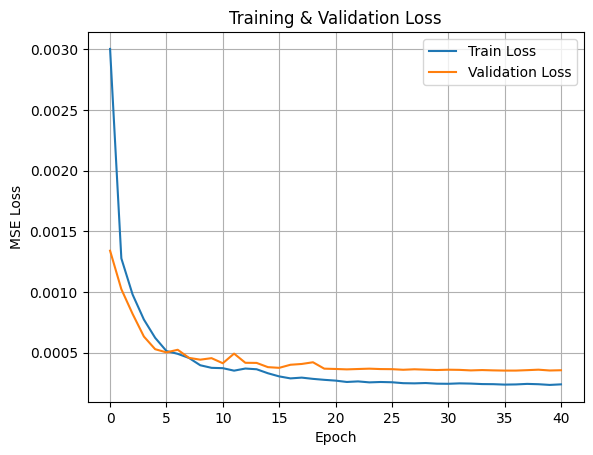

time: 218 ms (started: 2025-06-11 12:51:24 +03:00)


In [174]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Saving trained model

In [175]:
model.load_state_dict(best_model)

torch.save(model.state_dict(), "mlp_model.pt")
print("Model saved to mlp_model.pt")

Model saved to mlp_model.pt
time: 32 ms (started: 2025-06-11 12:51:24 +03:00)


## Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
import numpy as np
import torch

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    non_zero_mask = np.abs(y_true) > 1e-6
    y_true_filtered = y_true[non_zero_mask]
    y_pred_filtered = y_pred[non_zero_mask]

    return np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100


def accuracy_within_percentage(y_true, y_pred, threshold_percent=10):
    error_pct = np.abs((y_true - y_pred) / y_true) * 100
    return np.mean(error_pct <= threshold_percent) * 100

def evaluate_predictions(y_true, y_pred, label="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    acc10 = accuracy_within_percentage(y_true, y_pred, 10)
    acc20 = accuracy_within_percentage(y_true, y_pred, 20)
    acc30 = accuracy_within_percentage(y_true, y_pred, 30)

    print(f"\n{label} Results:")
    print(f"MAE:  {mae:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"R²:   {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"MedAE: {medae:.2f}")
    print(f"Accuracy within ±10%: {acc10:.2f}%")
    print(f"Accuracy within ±20%: {acc20:.2f}%")
    print(f"Accuracy within ±30%: {acc30:.2f}%")

model.load_state_dict(best_model)
model.eval()

with torch.no_grad():
    y_train_pred = model(X_train_tensor, city_train_tensor).cpu().numpy()
    y_val_pred   = model(X_val_tensor,   city_val_tensor).cpu().numpy()
    y_test_pred  = model(X_test_tensor,  city_test_tensor).cpu().numpy()

evaluate_predictions(y_train_part.values.ravel(), y_train_pred.ravel(), "Train Set")
evaluate_predictions(y_val.values.ravel(), y_val_pred.ravel(), "Validation Set")
evaluate_predictions(y_test_tensor.cpu().numpy().ravel(), y_test_pred.ravel(), "Test Set")



📊 Train Set Results:
MAE:  0.01
MSE:  0.00
R²:   0.9473
MAPE: 23.22%
MedAE: 0.01
Accuracy within ±10%: 53.06%
Accuracy within ±20%: 76.70%
Accuracy within ±30%: 86.43%

📊 Validation Set Results:
MAE:  0.02
MSE:  0.00
R²:   0.8864
MAPE: 23.10%
MedAE: 0.01
Accuracy within ±10%: 46.53%
Accuracy within ±20%: 72.11%
Accuracy within ±30%: 84.65%

📊 Test Set Results:
MAE:  0.01
MSE:  0.00
R²:   0.9128
MAPE: 25.21%
MedAE: 0.01
Accuracy within ±10%: 48.22%
Accuracy within ±20%: 74.06%
Accuracy within ±30%: 85.35%
time: 125 ms (started: 2025-06-11 12:51:24 +03:00)


C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\1935142757.py:17: RuntimeWarning: divide by zero encountered in divide
  error_pct = np.abs((y_true - y_pred) / y_true) * 100


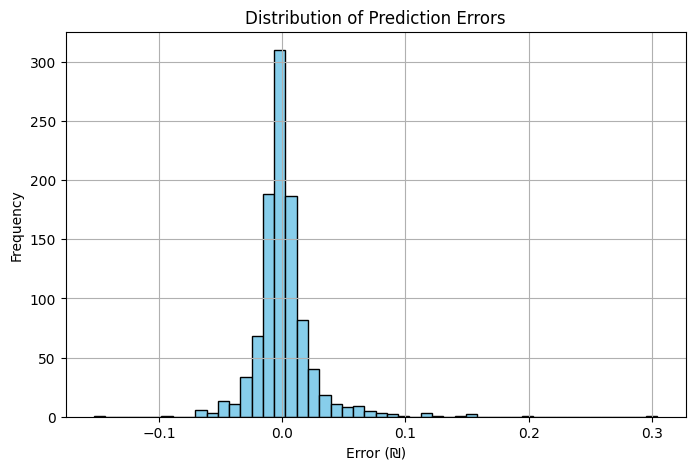

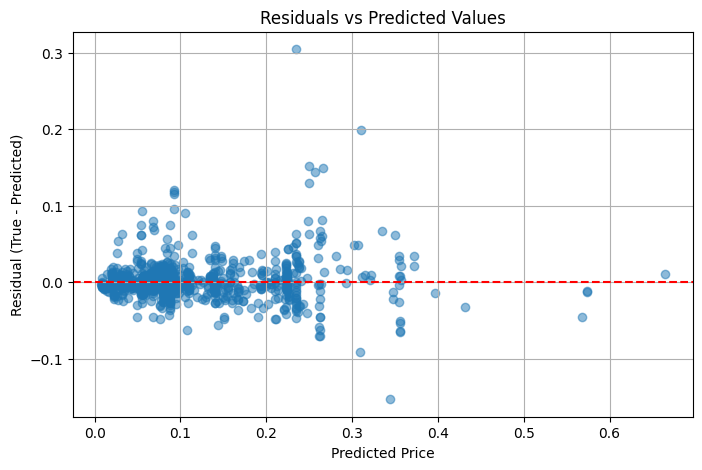

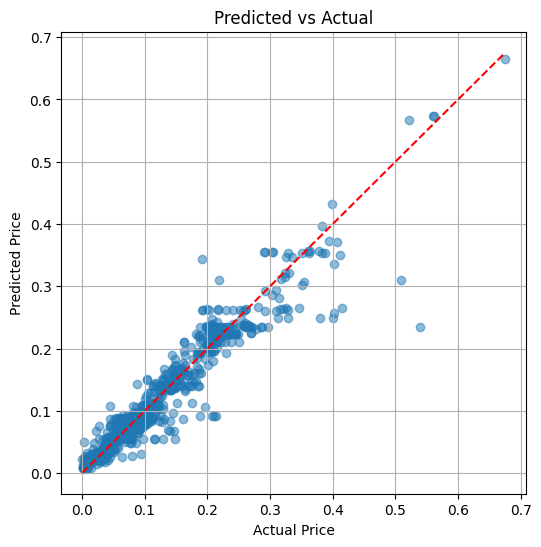

time: 610 ms (started: 2025-06-11 12:51:24 +03:00)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

y_true = y_test_tensor.cpu().numpy().ravel()
y_pred = y_test_pred.ravel()

df_eval = pd.DataFrame({
    'True': y_true,
    'Predicted': y_pred
})
df_eval['Error'] = df_eval['True'] - df_eval['Predicted']
df_eval['AbsError'] = np.abs(df_eval['Error'])
df_eval['Error%'] = df_eval['AbsError'] / df_eval['True'] * 100

plt.figure(figsize=(8, 5))
plt.hist(df_eval['Error'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (₪)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(df_eval['Predicted'], df_eval['Error'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(df_eval['True'], df_eval['Predicted'], alpha=0.5)
plt.plot([df_eval['True'].min(), df_eval['True'].max()],
         [df_eval['True'].min(), df_eval['True'].max()],
         'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()


## Test environment

In [178]:
import pandas as pd
import json

time: 0 ns (started: 2025-06-11 12:51:25 +03:00)


In [179]:
X_columns = pd.read_csv("model_columns.csv", header=None).squeeze().tolist()

time: 16 ms (started: 2025-06-11 12:51:25 +03:00)


In [180]:
with open('scaler_minmax.json', 'r') as f:
    scaler_minmax = json.load(f)

with open('price_minmax.json', 'r') as f:
    price_minmax = json.load(f)

time: 0 ns (started: 2025-06-11 12:51:25 +03:00)


In [181]:
def normalize_value(value, min_val, max_val):
    if max_val > min_val:
        return (value - min_val) / (max_val - min_val)
    else:
        return 0.0

def find_all_columns_by_substring(columns, value):
    value = str(value).strip().lower()
    matches = [col for col in columns if value in col.lower()]
    return matches

def find_columns_exact_match(columns, value):
    value = str(value).strip().lower()
    matches = [col for col in columns if col.lower() == value]
    return matches

time: 0 ns (started: 2025-06-11 12:51:25 +03:00)


In [182]:
def predict_price_mlp(user_input: dict, model, X_columns, scaler_minmax, price_minmax, default_values=None):
    if default_values is None:
        default_values = {
            'Units': 1,
            'Area m2': 500,
            'block': '0.0',
            'Committee year': '2025.0',
            'committee month': '6.0',
            'region': 'Unknown',
            'city': 'Unknown',
            'dist_to_kindergarten': 500,
            'dist_to_school': 500,
            'dist_to_university': 1000,
            'dist_to_bus_stop': 200,
            'dist_to_train_station': 1500,
            'dist_to_park': 300,
            'dist_to_mall': 1000,
            'dist_to_supermarket': 300,
            'dist_to_beach': 5000,
            'dist_to_place_of_worship': 400
        }

    input_df = pd.DataFrame([0] * len(X_columns), index=X_columns).T

    for col in ['Units', 'Area m2']:
        val = float(user_input.get(col, default_values[col]))
        min_val = scaler_minmax[col]['min']
        max_val = scaler_minmax[col]['max']
        input_df.at[0, col] = normalize_value(val, min_val, max_val)

    block_col = f"Block_{user_input.get('block', default_values['block'])}"
    if block_col in X_columns:
        input_df.at[0, block_col] = 1

    year_col = f"Committee_year_{user_input.get('Committee year', default_values['Committee year'])}"
    month_col = f"Committee_month_{user_input.get('committee month', default_values['committee month'])}"
    if year_col in X_columns:
        input_df.at[0, year_col] = 1
    if month_col in X_columns:
        input_df.at[0, month_col] = 1

    distance_features = [
        'dist_to_kindergarten', 'dist_to_school', 'dist_to_university',
        'dist_to_bus_stop', 'dist_to_train_station', 'dist_to_park',
        'dist_to_mall', 'dist_to_supermarket', 'dist_to_beach',
        'dist_to_place_of_worship'
    ]

    for col in distance_features:
        val = float(user_input.get(col, default_values[col]))
        min_val = scaler_minmax[col]['min']
        max_val = scaler_minmax[col]['max']
        input_df.at[0, col] = normalize_value(val, min_val, max_val)

    if input_df.empty:
        raise ValueError("No records were found match to the query.")

    with open("city_mapping.json", "r", encoding="utf-8") as f:
        city_mapping = json.load(f)

    city_name = user_input.get('city', default_values['city'])
    city_index = city_mapping.get(city_name, -1)
    if city_index == -1:
        raise ValueError(f"City '{city_name}' not found in city_mapping.json")

    input_tensor = torch.tensor(input_df.values, dtype=torch.float32).to(device)
    city_tensor = torch.tensor([city_index], dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor, city_tensor).item()

    price_min = price_minmax["min"]
    price_max = price_minmax["max"]
    predicted_price_per_m2 = prediction * (price_max - price_min) + price_min

    return predicted_price_per_m2


time: 0 ns (started: 2025-06-11 12:51:25 +03:00)


### Testing on existing record in Dataset

In [183]:
import torch
import pandas as pd
import json

def predict_from_record(row, model, price_minmax):
    input_df = pd.DataFrame([0] * len(X_columns), index=X_columns).T

    numeric_features = ['Units', 'Area m2']
    for col in numeric_features:
        if col in row:
            input_df.at[0, col] = row[col]

    for col in row.index:
        if col.startswith(('Block_', 'Region_', 'Committee_year_', 'Committee_month_')) and row[col] == 1:
            input_df.at[0, col] = 1

    with open("city_mapping.json", "r", encoding="utf-8") as f:
        city_mapping = json.load(f)

    if "City_Index" not in row:
        raise ValueError("Missing City_Index in the input row")

    city_index = int(row["City_Index"])
    city_tensor = torch.tensor([city_index], dtype=torch.long).to(device)

    input_tensor = torch.tensor(input_df.values, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        prediction_norm = model(input_tensor, city_tensor).item()

    price_min = price_minmax["min"]
    price_max = price_minmax["max"]
    prediction = prediction_norm * (price_max - price_min) + price_min

    true_norm = row['Price per m2']
    true_price = true_norm * (price_max - price_min) + price_min

    print(f"Prediction: {prediction:,.2f} ₪")
    print(f"Actual price: {true_price:,.2f} ₪")
    print(f"Deviation: {abs(prediction - true_price) / true_price * 100:.2f}%")
    return prediction, true_price


time: 16 ms (started: 2025-06-11 12:51:25 +03:00)


In [184]:
row = df.sample(1).iloc[0]
predict_from_record(row, model, price_minmax)

Prediction: 1,061.76 ₪
Actual price: 1,004.00 ₪
Deviation: 5.75%


C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\3192405487.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3644067796610169' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = row[col]


(1061.760747280589, np.float64(1003.9999999999997))

time: 15 ms (started: 2025-06-11 12:51:25 +03:00)


## Random records from data

In [185]:
import torch
import numpy as np
import pandas as pd
import json

def evaluate_on_random_samples(df, model, scaler_minmax, price_minmax, X_columns, n=20):
    errors = []

    with open("city_mapping.json", "r", encoding="utf-8") as f:
        city_mapping = json.load(f)

    for _, row in df.sample(n=n, random_state=42).iterrows():
        input_df = pd.DataFrame([0] * len(X_columns), index=X_columns).T

        numeric_features = ['Units', 'Area m2',
                            'dist_to_kindergarten', 'dist_to_school', 'dist_to_university',
                            'dist_to_bus_stop', 'dist_to_train_station', 'dist_to_park',
                            'dist_to_mall', 'dist_to_supermarket', 'dist_to_beach',
                            'dist_to_place_of_worship']

        for col in numeric_features:
            val = row[col]
            min_val = scaler_minmax[col]['min']
            max_val = scaler_minmax[col]['max']
            input_df.at[0, col] = normalize_value(val, min_val, max_val)

        for col in row.index:
            if row[col] == 1 and col in input_df.columns:
                input_df.at[0, col] = 1

        if "City_Index" not in row:
            raise ValueError("Missing City_Index in the input data")

        city_index = int(row["City_Index"])
        city_tensor = torch.tensor([city_index], dtype=torch.long).to(device)

        input_tensor = torch.tensor(input_df.values, dtype=torch.float32).to(device)

        model.eval()
        with torch.no_grad():
            pred_norm = model(input_tensor, city_tensor).item()

        pred = pred_norm * (price_minmax["max"] - price_minmax["min"]) + price_minmax["min"]
        true = row["Price per m2"] * (price_minmax["max"] - price_minmax["min"]) + price_minmax["min"]
        error_pct = abs(pred - true) / true * 100
        errors.append(error_pct)

    print(f"Mean error: {np.mean(errors):.2f}%")
    print(f"Median error: {np.median(errors):.2f}%")
    print(f"Maximum error: {np.max(errors):.2f}%")
    print(f"Minimum error: {np.min(errors):.2f}%")


time: 0 ns (started: 2025-06-11 12:51:25 +03:00)


In [186]:
evaluate_on_random_samples(df, model, scaler_minmax, price_minmax,X_columns, n=20)

C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\2780202512.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\2780202512.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.21037527334978806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\2780202512.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.00021904026706814973' has dtype incompatible with int64, please explicitly cas

Mean error: 26.99%
Median error: 20.54%
Maximum error: 120.97%
Minimum error: 0.13%
time: 282 ms (started: 2025-06-11 12:51:25 +03:00)


C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\2780202512.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.16' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\2780202512.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.21014662687827212' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\2780202512.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0002181533881743194' has dtype incompatible with int64, please explicitly cas

# New query

In [ ]:
user_input = {
    'Units': 1,
    'Area m2': 543,
    'block': '38761.0',
    'Committee year': '2024.0',
    'committee month': '7.0',
    'region': 'דרום',
    'city': 'באר שבע , רקפות',
    'dist_to_kindergarten': 500,
    'dist_to_school': 500,
    'dist_to_university': 1000,
    'dist_to_bus_stop': 200,
    'dist_to_train_station': 1500,
    'dist_to_park': 300,
    'dist_to_mall': 1000,
    'dist_to_supermarket': 300,
    'dist_to_beach': 5000,
    'dist_to_place_of_worship': 400
}

predicted_price = predict_price_mlp(user_input, model, X_columns, scaler_minmax, price_minmax)
total_price = predicted_price * user_input['Area m2']

print(f"\nPredicted price per m²: {predicted_price:,.2f} ₪")
print(f"Total price for this area: {total_price:,.2f} ₪")


Predicted price per m²: 1,307.13 ₪
Total price for this area: 709,771.56 ₪
time: 31 ms (started: 2025-06-11 12:51:26 +03:00)


C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\2184327434.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4467312348668281' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\2184327434.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.010821824855730165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
C:\Users\idanb\AppData\Local\Temp\ipykernel_20780\2184327434.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.06810110696338102' has dtype incompatible with int64, please expl

## Validation of input
#### checks if the input match the columns in the model.

In [188]:
def validate_input_against_columns(user_input, X_columns):
    warnings = []
    activated = []

    block = user_input.get('block')
    if block is not None:
        block_col = f"Block_{float(block):.1f}"
        if block_col in X_columns:
            activated.append(block_col)
        else:
            warnings.append(f"Block column '{block_col}' not found.")

    year = user_input.get('Committee year')
    if year is not None:
        year_col = f"Committee_year_{float(year):.1f}"
        if year_col in X_columns:
            activated.append(year_col)
        else:
            warnings.append(f"Committee year column '{year_col}' not found.")

    month = user_input.get('committee month')
    if month is not None:
        month_col = f"Committee_month_{float(month):.1f}"
        if month_col in X_columns:
            activated.append(month_col)
        else:
            warnings.append(f"Committee month column '{month_col}' not found.")

    for field in ['city', 'region']:
        val = user_input.get(field, '').strip().lower()
        matches = [col for col in X_columns if val in col.lower()]
        if matches:
            activated.extend(matches)
        else:
            warnings.append(f"No column {field} found.")

    if warnings:
        print("Warnings features:")
        for w in warnings:
            print(" -", w)

    if activated:
        print("\nColumns that will be activated for this input:")
        for col in activated:
            print("  -", col)
    else:
        print("\n No one-hot columns matched the input.")

time: 0 ns (started: 2025-06-11 12:51:26 +03:00)


In [189]:
validate_input_against_columns(user_input, X.columns)

Warnings features:
 - No column city found.

Columns that will be activated for this input:
  - Block_38761.0
  - Committee_year_2024.0
  - Committee_month_7.0
  - Region_דרום
time: 0 ns (started: 2025-06-11 12:51:26 +03:00)


### Export all predictions

In [190]:
!pip install openpyxl

time: 1.44 s (started: 2025-06-11 12:51:26 +03:00)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
def export_predictions_to_excel(X_data, y_true, city_series, model, price_minmax,
                                filename="model_predictions.xlsx",
                                high_error_filename="high_errors.xlsx",
                                error_threshold=50):
    with open("index_to_city.json", "r", encoding="utf-8") as f:
        index_to_city = json.load(f)

    model.eval()
    with torch.no_grad():
        city_tensor = torch.tensor(city_series.values, dtype=torch.long).to(device)
        x_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
        preds_norm = model(x_tensor, city_tensor).cpu().numpy().flatten()



    price_min = price_minmax["min"]
    price_max = price_minmax["max"]

    def inv(x): return x * (price_max - price_min) + price_min

    if isinstance(y_true, pd.Series):
        y_true_array = y_true.to_numpy()
    else:
        y_true_array = y_true

    if len(y_true_array.shape) > 1:
        y_true_array = y_true_array.flatten()

    preds_shekel = inv(preds_norm)
    y_true_shekel = inv(y_true_array)

    errors = np.abs(preds_shekel - y_true_shekel)
    errors_pct = errors / y_true_shekel * 100

    city_names = city_series.map(lambda idx: index_to_city.get(str(int(idx)), "Unknown")).values

    df_results = pd.DataFrame({
        "City": city_names,
        "Predicted Price per m² (₪)": preds_shekel,
        "Actual Price per m² (₪)": y_true_shekel,
        "Absolute Error (₪)": errors,
        "Percentage Error (%)": errors_pct
    })

    df_results.to_excel(filename, index=False)
    print(f"Predictions exported to '{filename}' with {len(df_results)} rows.")

    df_high_error = df_results[df_results["Percentage Error (%)"] > error_threshold]
    df_high_error.to_excel(high_error_filename, index=False)
    print(f"{len(df_high_error)} rows with error > {error_threshold}% exported to '{high_error_filename}'.")

    mean_pct_error = errors_pct.mean()
    median_pct_error = np.median(errors_pct)
    print(f"Mean Percentage Error: {mean_pct_error:.2f}%")
    print(f"Median Percentage Error: {median_pct_error:.2f}%")


time: 0 ns (started: 2025-06-11 12:51:27 +03:00)


In [ ]:
city_test_idx = city_test_tensor.cpu().numpy()
export_predictions_to_excel(X_test, y_test, pd.Series(city_test_idx), model, price_minmax)

Predictions exported to 'model_predictions.xlsx' with 1010 rows.
55 rows with error > 50% exported to 'high_errors.xlsx'.
Mean Percentage Error: 16.98%
Median Percentage Error: 9.82%
time: 171 ms (started: 2025-06-11 12:51:27 +03:00)
